# Подключение необходимых для работы библиотек

In [11]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown

from typing import Callable


# Нелинейное уравнение

Аристова, Завьялова, Лобанов, IV.12.4, вариант e)

![title](res/variant_eq.png)

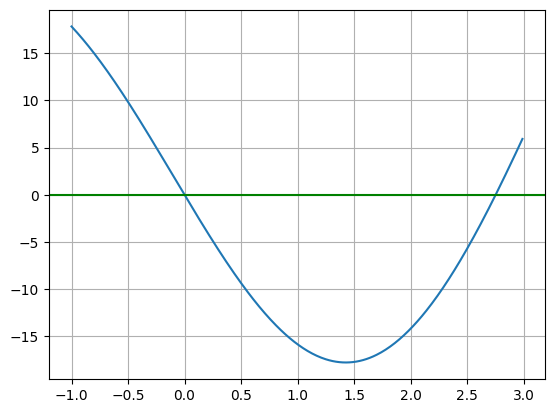

In [12]:
# Prepare sympy
x = sym.Symbol('x')
sym.init_printing()

# Function and it's derivative
sym_func = x**2 - 20 * sym.sin(x)
sym_deriv = sym.diff(sym_func, x)
display(sym_func)
display(sym_deriv)
func  = sym.lambdify(x, sym_func,  "numpy")
deriv = sym.lambdify(x, sym_deriv, "numpy")

x = np.arange(-1, 3, 0.01)
plt.plot(x, func(x))
plt.axhline(y=0, c='green')
plt.grid(True)




----------------------------------------------------------------------------------------
interp = Newton(x_use, y_use)
t = np.linspace(min(x_use), max(x_use), 100)
plt.plot(t, interp(t))

plt.plot(x_use[5],y_use[5],'ro') 
plt.scatter(x_use, y_use)
print(x_use)
print(y_use)

print('Interpolation: {:.0f}'.format(interp(x_use[5])))
print('Real: {:.0f}'.format(y_use[5]))
print('Error: {:.2f} %'.format(100 * abs(y_use[5] - interp(x_use[5])) / y_use[5]))

## Метод Ньютона

In [16]:
def solveEqNewton(func, x0, n_iter, precision, left, right):
    deriv = lambda x, h: (func(x+h) - func(x-h)) / (2*h)
    diff = []
    
    x = x0
    h = np.min([np.abs(x - left), np.abs(x - right)])

    for i in range(n_iter):
        old_x = x
        x = x - func(x) / deriv(x, h)

        d = np.abs(x - old_x)
        diff.append(d)
        if d <= precision:
            break

        h = d

    return x, diff

Newton's method
Root: x = 2.75294663
Reference: x = 2.75294663


C:\Users\fox5r\AppData\Local\Temp\ipykernel_3940\1774738248.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(range(len(diff)), np.log10(diff))


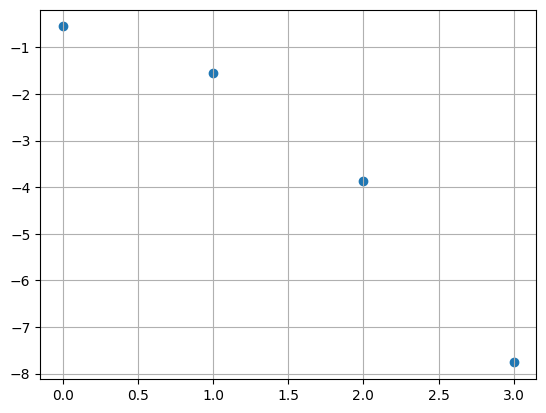

In [24]:
print("Newton's method")

x, diff = solveEqNewton(func, 2.5, 15, 1e-8, 2, 3)
print(f"Root: x = {x:.8f}")

xref = sp.optimize.fsolve(func, 2.5)
print(f"Reference: x = {xref[0]:.8f}")

plt.scatter(range(len(diff)), np.log10(diff))
plt.grid()

## Метод простой итерации

In [ ]:
def solveEqFpi(fpi, x0, n_iter, precision, left, right):
    
    deriv = lambda x, h: (fpi(x+h) - fpi(x-h)) / (2*h)
    h = np.min([np.abs(x0 - left), np.abs(x0 - right)])
    if np.abs(deriv(x0, h)) < 1:
        raise RuntimeError(f"FPI method does not converge: {deriv(x0, h)=}")

    x = x0
    diff = []

    for i in range(n_iter):
        if lefft < x < right:
            raise RuntimeError(f"Out of bounds on iter {i}.")
        old_x = x
        x = fpi(x)
        d = np.abs(x - old_x)
        diff.append(d)
        if d < precision:
            break
    

    return x, diff

Root: x = 0.30401360
Reference: x = 0.00000000


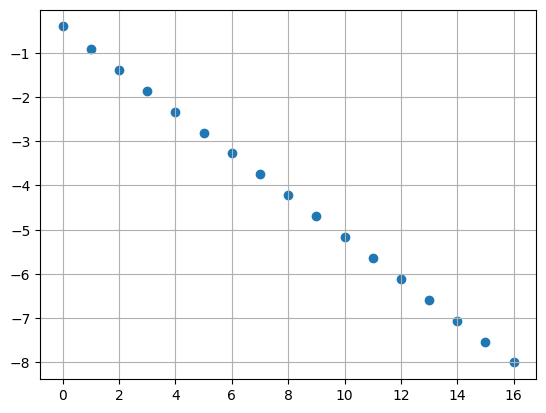

In [ ]:
# Prepare sympy
x = sym.Symbol('x')
sym.init_printing()

sym_fpi_func  = -sym.atan(x - 1) / 2
sym_fpi_deriv = sym.diff(sym_fpi_func, x)
fpi_func  = sym.lambdify(x, sym_fpi_func,  "numpy")
fpi_deriv = sym.lambdify(x, sym_fpi_deriv, "numpy")

x, diff = solveEqFpi(fpi_func, 0, 20, 1e-8, -1, 1)
print(f"Root: x = {x:.8f}")

xref = sp.optimize.fsolve(func, 0)
print(f"Reference: x = {xref[0]:.8f}")

plt.scatter(range(len(diff)), np.log10(diff))
plt.grid()    

# Решение нелинейной системы

Аристова, Завьялова, Лобанов, IV.12.7, вариант д)

![title](res/variant_system.png)

In [ ]:
f = lambda x: np.array([
    np.sin(x[0]) - x[1] - 1.32,
    np.cos(x[1]) - x[0] + 0.85,
])

## Метод Ньютона

In [ ]:
def partial(f: C, x: list, var_index: int, h: int):
    dimension = len(x)
    vec_h = np.zeros(dimension)
    vec_h[var_index] = h

    return (f(x+vec_h) - f(x-vec_h)) / (2 * h)

def getJacobi(f, x, h):
    dim = len(f(x))
    J = np.zeros((dim, dim))

    for i in range(dim):
        for j in range(dim):
            J[i][j] = partial(lambda x: f(x)[i], x, j, h[i])
    
    return J

def solveSystemNewton(f, x0, n_iter, precision, bl, tr):
    dim = len(f(x0))
    h = [np.min([np.abs(x0[i] - bl[i]), np.abs(x0[i] - tr[i])]) for i in range(dim)]
    x = x0

    diff = []
    for i in range(n_iter):
        old_x = x
        x -= np.matmul(np.linalg.inv(getJacobi(f, x, h)), f(x))
        d = np.abs(x - old_x)
        h = d
        d_norm = np.linalg.norm(d, ord=np.inf)
        diff.append(d_norm)
        if d_norm < precision:
            break

    return x, diff

Localization: 1.5707963267948966 < x0 = 1.791 < 2.0943951023931953, -0.35 < y0 = -0.344 < -0.34
Solution:  (1.79134, -0.34422)
Reference: (1.79134, -0.34422)


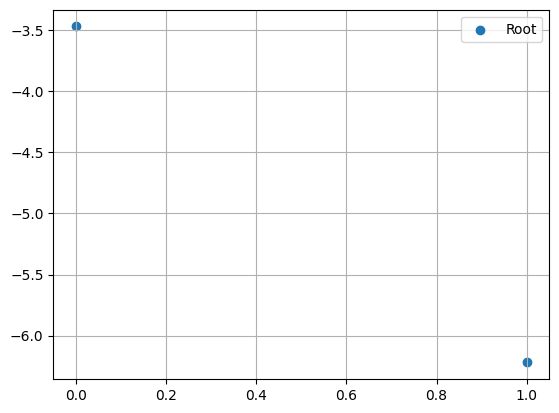

In [ ]:
def solve(label, x0, bl, tr):
    print(f"Localization: {bl[0]} < x0 = {x0[0]} < {tr[0]}, {bl[1]} < y0 = {x0[1]} < {tr[1]}")
    x, diff = solveSystemNewton(f, x0, 10, 1e-5, bl, tr)
    print(f"Solution:  ({x[0]:.5f}, {x[1]:.5f})")

    xref = sp.optimize.fsolve(f, x0)
    print(f"Reference: ({xref[0]:.5f}, {xref[1]:.5f})")

    plt.scatter(range(len(diff)), np.log10(diff), label=label)
    plt.grid(True)
    plt.legend()

solve("Root", [ 1.791, -0.344], [ np.pi/2, -0.35], [ 2*np.pi/3, -0.34])

## Метод простой итерации

In [ ]:
def solveSystemFpi(fpi, x0, n_iter, precision, bl, tr):
    dim = len(fpi(x0))
    h = 1e-3 * np.array([np.min([np.abs(x0[i] - bl[i]), np.abs(x0[i] - tr[i])]) for i in range(dim)])
    x = x0

    J = getJacobi(fpi, x0, h)
    display(J)
    J_norm = np.linalg.norm(J, ord=np.inf)
    print(J_norm)
    if J_norm > 1 or np.isnan(J_norm):
        raise RuntimeError("WARNING: FPI does not converge.")

    diff = []
    for i in range(n_iter):
        if np.all(bl < x) and np.all(x < tr):
            raise RuntimeError( f"Gone out of bounds on iter {i}. Diff: {diff}.")
        old_x = x
        x = fpi(x)
        d = np.abs(x - old_x)
        d_norm = np.linalg.norm(d, ord=np.inf)
        diff.append(d_norm)
        if d_norm < precision:
            break

    return x, diff

--------------------------------------------------------------------------------
Localization: 1.5707963267948966 < x0 = 1.792 < 2.0943951023931953, -0.4 < y0 = -0.344 < -0.3


array([[ 0.        ,  0.33725543],
       [-0.21940413,  0.        ]])

0.3372554301034726
Solution: (1.79134, -0.34422)
Reference: (1.79134, -0.34422)


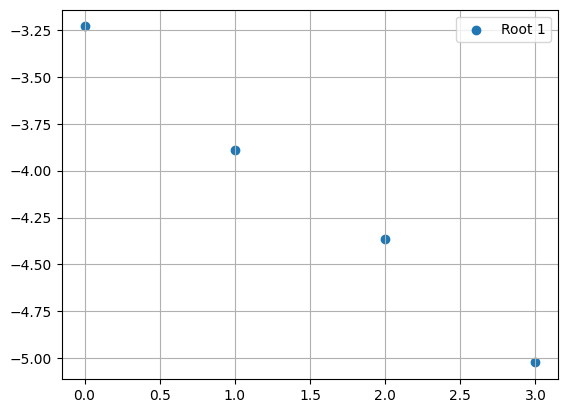

In [ ]:
f = lambda x: np.array([
    np.sin(x[0]) - x[1] - 1.32,
    np.cos(x[1]) - x[0] + 0.85,
])

def solve(label, fpi, x0, bl, tr):
    print(80 * "-")
    print(f"Localization: {bl[0]} < x0 = {x0[0]} < {tr[0]}, {bl[1]} < y0 = {x0[1]} < {tr[1]}")
    
    x, diff = solveSystemFpi(fpi, x0, 30, 1e-5, bl, tr)
    print(f"Solution: ({x[0]:.5f}, {x[1]:.5f})")
    
    xref = sp.optimize.fsolve(f, x0)
    print(f"Reference: ({xref[0]:.5f}, {xref[1]:.5f})")
    
    plt.scatter(range(len(diff)), np.log10(diff), label=label)
    plt.grid(True)
    plt.legend()

f_1 = lambda x: np.array([
    np.cos(x[1]) + 0.85,
    np.sin(x[0]) - 1.32
])
solve("Root 1", f_1, [ 1.792, -0.344], [ np.pi/2, -0.4], [ 2*np.pi/3, -0.3])